In [1]:
## Import libraries

import pandas as pd # type: ignore
import yfinance as yf # type: ignore
import numpy as np # type: ignore
import statsmodels.api as sm # type: ignore
import matplotlib.pyplot as plt

from scipy.stats import mstats
from datetime import datetime

from Functions import *

In [2]:
## Define variables to Model

# Dark Mode to Charts
fn_DarkMode()

# Ten years to Training Model
# Mount_Start, Commision = 10000, 0
Year_Start, Years_Train, Years_Test, Years_Validate = 2011, 10, 1, 1

Date_Start_Train, Date_End_Train = datetime(Year_Start, 1, 1), datetime(Year_Start + Years_Train - 1, 12, 31)
Date_Start_Test, Date_End_Test = datetime(Year_Start + Years_Train, 1, 1), datetime(Year_Start + Years_Train, 12, 31)
Date_Start_Vali, Date_End_Vali = datetime(Year_Start + Years_Train + Years_Test, 1, 1), datetime(Year_Start + Years_Train + Years_Test, 12, 31)

In [13]:
## Processing Data

# Stocks from index Mexico IPC
df_stocks = pd.read_csv("IPC_Stocks.csv")
Symbols = df_stocks["Symbol"].to_list()

# Get data from Yahoo Finance
df_Stocks = yf.download(Symbols, start = Date_Start_Train, end = Date_End_Train)
df_Stocks = df_Stocks["Adj Close"]
df_Stocks = df_Stocks.rename(columns = {"^MXX": "IPC"})

# Update NaN from IPC
df_Stocks.loc["2011-12-26", "IPC"] = 37217.97
df_Stocks.loc["2012-01-02", "IPC"] = 37335.03
df_Stocks.loc["2014-12-26", "IPC"] = 43002.17

# Filter Data Non NaN
Counts = df_Stocks.isnull().sum()
ColumnsNaN = Counts[Counts == 0].index
df_Stocks = df_Stocks[ColumnsNaN]

# Rename Columns
df_Stocks.rename(columns=lambda x: x.replace('.MX', ''), inplace=True)

# Get Returns
df_Returns = df_Stocks.pct_change().dropna()
df_Returns["IPC"] = round(df_Returns["IPC"].shift(-1), 6)
df_Returns["IPC_1"] = df_Returns["IPC"].shift(1)
df_Returns["IPC_2"] = df_Returns["IPC"].shift(2)
df_Returns = df_Returns.dropna()
df_Returns

[*********************100%%**********************]  36 of 36 completed


Ticker,AC,ALFAA,ALSEA,AMXB,ASURB,BIMBOA,BOLSAA,CEMEXCPO,CHDRAUIB,ELEKTRA,...,MEGACPO,OMAB,ORBIA,PE&OLES,PINFRA,TLEVISACPO,WALMEX,IPC,IPC_1,IPC_2
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-06,-0.012500,-0.001076,0.000767,0.003348,-0.013585,-0.005825,0.000000,-0.021723,-0.003727,-0.001013,...,0.014906,-0.002933,0.006515,-0.029937,-0.005358,-0.006498,0.002242,0.000290,-0.002754,0.003998
2011-01-07,0.002404,0.000231,-0.001534,0.002503,-0.004637,0.000472,-0.023755,0.008423,0.000000,-0.003783,...,-0.021562,0.000840,0.000893,-0.020273,0.002108,-0.006700,0.002797,-0.005769,0.000290,-0.002754
2011-01-10,0.007992,-0.027528,0.000000,-0.005548,-0.015107,-0.002172,-0.009419,-0.025816,0.004008,-0.002760,...,0.005749,-0.002519,-0.003792,-0.015774,-0.006310,0.008030,-0.003068,-0.009103,-0.005769,0.000290
2011-01-11,-0.015858,-0.013995,0.001536,-0.022315,-0.007884,-0.025085,0.003962,0.010132,0.001597,-0.009245,...,-0.006669,0.001684,0.010298,0.005358,-0.007526,-0.017365,-0.021538,-0.001722,-0.009103,-0.005769
2011-01-12,-0.013696,0.015157,0.004601,-0.001427,-0.004624,0.001554,-0.013417,0.003858,0.005049,-0.006102,...,0.004796,0.017834,0.005318,0.016491,0.002132,0.003080,0.001715,0.002815,-0.001722,-0.009103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-22,-0.017238,-0.047516,-0.017048,0.000000,0.007755,0.004050,-0.013411,-0.007820,-0.000717,-0.000186,...,-0.005696,0.006047,-0.005125,-0.038868,-0.023201,-0.013036,-0.004320,0.023370,-0.014904,-0.014304
2020-12-23,0.009348,0.071807,0.018526,-0.006849,0.003103,0.026341,0.013155,0.021675,0.005737,-0.002597,...,0.006427,0.038949,0.009407,0.010417,0.012058,0.027062,0.012834,-0.005163,0.023370,-0.014904
2020-12-24,-0.002081,-0.006347,0.005418,0.000000,-0.010951,-0.015260,0.020125,-0.011572,0.012121,0.001189,...,0.009302,-0.016507,0.007766,-0.007066,0.016285,-0.011920,-0.004640,0.011787,-0.005163,0.023370


In [14]:
## Correlation Matrix (Pearson)
df_Returns.corr()

Ticker,AC,ALFAA,ALSEA,AMXB,ASURB,BIMBOA,BOLSAA,CEMEXCPO,CHDRAUIB,ELEKTRA,...,MEGACPO,OMAB,ORBIA,PE&OLES,PINFRA,TLEVISACPO,WALMEX,IPC,IPC_1,IPC_2
Ticker,,,,,,,,,,,,,,,,,,,,,
AC,1.000000,0.228789,0.187372,0.063414,0.197195,0.281946,0.167954,0.239426,0.224052,0.112247,...,0.111630,0.198002,0.210891,0.169649,0.249017,0.166204,0.213397,0.010417,0.409755,0.060297
ALFAA,0.228789,1.000000,0.244337,0.105522,0.277369,0.283048,0.244559,0.315107,0.250928,0.164021,...,0.118079,0.272921,0.351754,0.194878,0.317593,0.256977,0.221965,0.029444,0.523143,0.063613
ALSEA,0.187372,0.244337,1.000000,0.089663,0.298840,0.206521,0.223882,0.266653,0.168599,0.086135,...,0.099765,0.277307,0.349711,0.146028,0.248293,0.188223,0.200317,0.048210,0.436124,0.075582
AMXB,0.063414,0.105522,0.089663,1.000000,0.121806,0.101403,0.088393,0.109173,0.093446,0.094315,...,0.025585,0.101019,0.097230,0.066332,0.094673,0.106399,0.084704,0.012076,0.236577,0.119851
ASURB,0.197195,0.277369,0.298840,0.121806,1.000000,0.242175,0.169386,0.286008,0.204482,0.105813,...,0.080569,0.425203,0.265442,0.142727,0.295242,0.321033,0.208036,0.070555,0.501220,0.021247
BIMBOA,0.281946,0.283048,0.206521,0.101403,0.242175,1.000000,0.230125,0.286748,0.306022,0.167526,...,0.147846,0.205365,0.304614,0.259911,0.272930,0.261843,0.263361,-0.009433,0.536888,0.011305
BOLSAA,0.167954,0.244559,0.223882,0.088393,0.169386,0.230125,1.000000,0.217937,0.207269,0.120091,...,0.149177,0.205386,0.254771,0.174850,0.243006,0.178524,0.187719,0.030606,0.394387,0.081520
CEMEXCPO,0.239426,0.315107,0.266653,0.109173,0.286008,0.286748,0.217937,1.000000,0.260156,0.139416,...,0.164774,0.250990,0.365816,0.222290,0.248965,0.340258,0.220726,0.045251,0.614229,0.033775
CHDRAUIB,0.224052,0.250928,0.168599,0.093446,0.204482,0.306022,0.207269,0.260156,1.000000,0.098244,...,0.108048,0.156676,0.239699,0.184619,0.214665,0.236807,0.254331,0.027212,0.402059,0.023392


<function matplotlib.pyplot.show(close=None, block=None)>

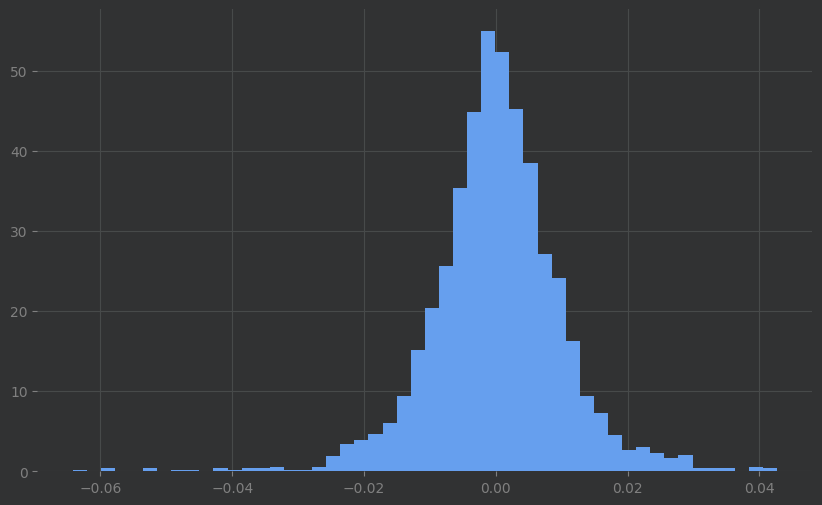

In [15]:
## Visualitization

# Normality Returns IPC
plt.figure(figsize=(10, 6))
plt.hist(df_Returns["IPC"], bins = 50, density = True)
plt.show

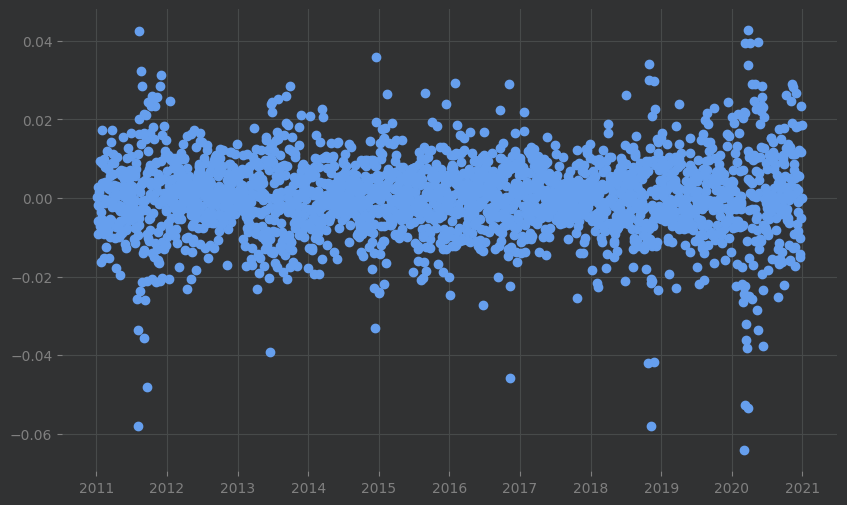

In [16]:
## Visualitization

# Scatterplot
plt.figure(figsize=(10, 6))
plt.scatter(df_Returns.index, df_Returns["IPC"])

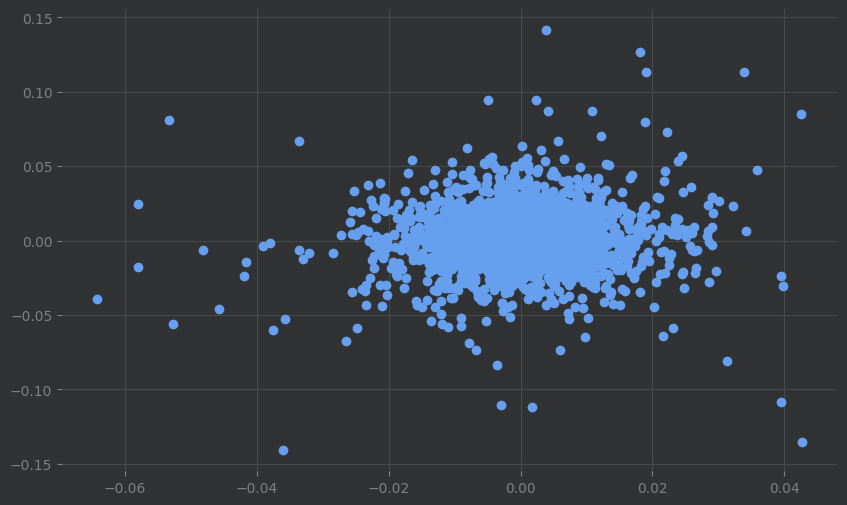

In [17]:
## Visualitization

# Scatterplot
plt.figure(figsize=(10, 6))
plt.scatter(df_Returns["IPC"], df_Returns["OMAB"])

In [18]:
## Regression Model

# Define variables y & X
y = df_Returns["IPC"]
X = df_Returns.drop(columns = ["IPC"])
X = sm.add_constant(X)

# Create Regression Model with Statsmodels
model = sm.OLS(y, X).fit()
print(model.summary())

## Analizing reults, we only get GFINBURO because p-value <= 0.05 => 0.003

                            OLS Regression Results                            
Dep. Variable:                    IPC   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1.568
Date:                Wed, 07 Aug 2024   Prob (F-statistic):             0.0239
Time:                        15:03:49   Log-Likelihood:                 8024.8
No. Observations:                2503   AIC:                        -1.599e+04
Df Residuals:                    2471   BIC:                        -1.580e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.073e-05      0.000      0.204      0.8

In [19]:
## Regression Model Adjust

# Define variables y & X
y = df_Returns["IPC"]
X = df_Returns[["OMAB", "GAPB"]]

# Create Regression Model with Statsmodels
model = sm.OLS(y, X).fit()
print(model.summary())

## Analizing reults, we only get GFINBURO because p-value <= 0.05 => 0.003
## Analizing reults, we drop GAPB because p-value > 0.05 => 0.198

                                 OLS Regression Results                                
Dep. Variable:                    IPC   R-squared (uncentered):                   0.005
Model:                            OLS   Adj. R-squared (uncentered):              0.005
Method:                 Least Squares   F-statistic:                              6.721
Date:                Wed, 07 Aug 2024   Prob (F-statistic):                     0.00123
Time:                        15:04:43   Log-Likelihood:                          8006.9
No. Observations:                2503   AIC:                                 -1.601e+04
Df Residuals:                    2501   BIC:                                 -1.600e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [20]:
## Regression Model Adjust

# Define variables y & X
y = df_Returns["IPC"]
X = df_Returns[["OMAB"]]

# Create Regression Model with Statsmodels
model = sm.OLS(y, X).fit()
print(model.summary())

## Analizing reults, we only get GFINBURO because p-value <= 0.05 => 0.003

                                 OLS Regression Results                                
Dep. Variable:                    IPC   R-squared (uncentered):                   0.005
Model:                            OLS   Adj. R-squared (uncentered):              0.004
Method:                 Least Squares   F-statistic:                              11.77
Date:                Wed, 07 Aug 2024   Prob (F-statistic):                    0.000611
Time:                        15:05:04   Log-Likelihood:                          8006.1
No. Observations:                2503   AIC:                                 -1.601e+04
Df Residuals:                    2502   BIC:                                 -1.600e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------